# L band data reduction

1. Nod subtraction 

This notebook replaces file #2.  However, you still have to run file #3 and #4 to dewarp and bin before registering the images.  

written by: Sarah Betti - May 2020

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel
from astropy.modeling import models, fitting
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

import glob
import datetime
import os

from photutils import make_source_mask
from photutils import source_properties
from photutils import detect_threshold, detect_sources

from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)


In [ ]:
from shift_methods import *

%load_ext autoreload
%autoreload 2

# PART 1: Nod subtraction

In [2]:
def find_outlier_pixels(data,tolerance=3,worry_about_edges=True):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #
    #
    #The function returns a list of hot pixels and also an image with with hot pixels removed

    from scipy.ndimage import median_filter
    blurred = median_filter(data, size=3)
    difference = data - blurred
    threshold = 8*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((np.abs(difference[1:-1,1:-1])>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column

    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    if worry_about_edges == True:
        height,width = np.shape(data)

        ###Now get the pixels on the edges (but not the corners)###

        #left and right sides
        for index in range(1,height-1):
            #left side:
            med  = np.median(data[index-1:index+2,0:2])
            diff = np.abs(data[index,0] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[0]]  ))
                fixed_image[index,0] = med

            #right side:
            med  = np.median(data[index-1:index+2,-2:])
            diff = np.abs(data[index,-1] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[index],[width-1]]  ))
                fixed_image[index,-1] = med

        #Then the top and bottom
        for index in range(1,width-1):
            #bottom:
            med  = np.median(data[0:2,index-1:index+2])
            diff = np.abs(data[0,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[0],[index]]  ))
                fixed_image[0,index] = med

            #top:
            med  = np.median(data[-2:,index-1:index+2])
            diff = np.abs(data[-1,index] - med)
            if diff>threshold: 
                hot_pixels = np.hstack(( hot_pixels, [[height-1],[index]]  ))
                fixed_image[-1,index] = med

        ###Then the corners###

        #bottom left
        med  = np.median(data[0:2,0:2])
        diff = np.abs(data[0,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[0]]  ))
            fixed_image[0,0] = med

        #bottom right
        med  = np.median(data[0:2,-2:])
        diff = np.abs(data[0,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[0],[width-1]]  ))
            fixed_image[0,-1] = med

        #top left
        med  = np.median(data[-2:,0:2])
        diff = np.abs(data[-1,0] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[0]]  ))
            fixed_image[-1,0] = med

        #top right
        med  = np.median(data[-2:,-2:])
        diff = np.abs(data[-1,-1] - med)
        if diff>threshold: 
            hot_pixels = np.hstack(( hot_pixels, [[height-1],[width-1]]  ))
            fixed_image[-1,-1] = med

    return hot_pixels,fixed_image     




#function to run find outlier pixel function
def data_corr(image):
    ''' takes out outliers, noise offsets in 64x1024 channels and row gradiant at row 451.'''
    H, im = find_outlier_pixels(image, worry_about_edges=False)  
    return im

def reduce_data(stack):
    '''goes through the rows and column channels and subtracts off the median'''
    filtered_im = sigma_clip(stack, sigma=2, masked=True)
    a = np.array([0,451, 1024])
    for i in np.arange(len(a)-1):
        row = stack[:,a[i]:a[i+1],:]  
        filtered_row = filtered_im.data[:,a[i]:a[i+1],:]  
        med = np.nanmedian(filtered_row, axis=(1,2))
        stack[:,a[i]:a[i+1],:] = (row.T - med).T

    filtered_medsubfin = sigma_clip(stack, sigma=2, masked=True)
    a = np.arange(0, np.shape(stack)[1]-1, 64)
    a = np.append(a, np.shape(stack)[1])
    for i in np.arange(len(a)-1):
        col = stack[:,:, a[i]:a[i+1]] 
        filtered_col = filtered_medsubfin.data[:,:, a[i]:a[i+1]]
        med = np.nanmedian(filtered_col, axis=(1,2))
        stack[:,:, a[i]:a[i+1]] = (col.T - med).T
    return stack

def run(data_nod, data, nums, bkg_nums):# FIND MEDIAN OF NOD IMAGES
    maskbadpix_nod = np.zeros((int(len(data_nod)), int(data_nod.shape[1]), int(data_nod.shape[2])))
    for im in np.arange(data_nod.shape[0]):
        print('bkg image:', im+1, end='\r')
        maskbadpix_nod[im,:,:] = data_corr(data_nod[im, :, :])
    print() 
    medsub_fin_nod = reduce_data(maskbadpix_nod)           
    median_data_nod = np.nanmedian(medsub_fin_nod, axis=0)

     # RUN THROUGH BKG SUBTRACTION FOR ALL DATA IMAGES
    maskbadpix_data = np.zeros((len(data), int(data.shape[1]), int(data.shape[2])))
    for im in np.arange(data.shape[0]):
        print('data image:', im+1, end='\r')
        # reduce data
        data_reduced = data_corr(data[im,:,:])
        # subtract off median background
        maskbadpix_data[im,:,:] = data_reduced
    print()
    medsub_fin_data = reduce_data(maskbadpix_data)
    bkg_data_reduced_FINAL = medsub_fin_data - median_data_nod

     # mask and subtract off gradiant in image
    mask_im = np.copy(bkg_data_reduced_FINAL)
    mask_im[:,:,413-150:413+150] = np.nan
    a = np.array([0,451, 1024])
    for k in np.arange(len(a)-1):
        print('working on: ', a[k], "-", a[k+1], end='\r')
        row = mask_im[:,a[k]:a[k+1],:]  
        row2 = bkg_data_reduced_FINAL[:,a[k]:a[k+1],:]
        med = np.nanmedian(row, axis=(1,2))
        bkg_data_reduced_FINAL[:,a[k]:a[k+1],:] = (row2.T - med).T
    print()
    plt.figure()
    plt.imshow(bkg_data_reduced_FINAL[0,:,:])
    plt.title('Final Nod subtraction')
    plt.show()
    
    hdr.append(('COMMENT', f'nod bkg subtracted with {bkg_nums}'), end=True)
    print(f'final_lm_{date}_{nums}.fits')
    fits.writeto(f'{datadir}3bkg_sub_1x1/{target}/{filt}/final_lm_{date}_{nums}.fits', bkg_data_reduced_FINAL, hdr, overwrite=True)

## Data directory

In [3]:
datadir =  '/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/'
target= 'HD39925'
filt = 'Lprime'
date = '140213'

# Run reduction

This is more manual than file #2; however, it is because things weren't working when I tried to do it automatic because up and down nods got saved into 1 cube.  If this is not the case for you, then you can probaly automate it.   

To run the following cell, you have to manually put in the first and last number of the cube file.  Then, create a list of the index where the cube frames flip from up to down to up nods.    

[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900 950]
[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900
 950  -1]
20
0
0 50 3451 3500
50 100 3501 3550


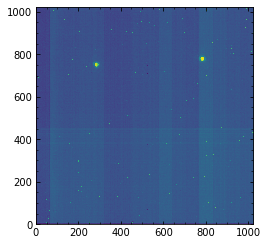

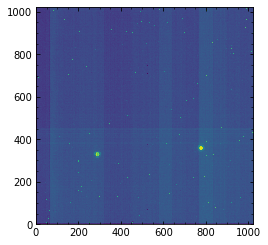


bkg image: 50
data image: 50
working on:  451 - 1024


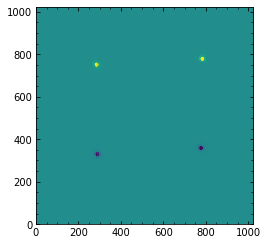

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03451_03500.fits
1
50 100 3501 3550
100 150 3551 3600


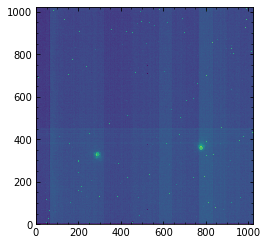

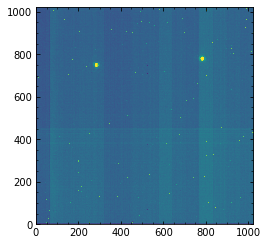


bkg image: 50
data image: 50
working on:  451 - 1024


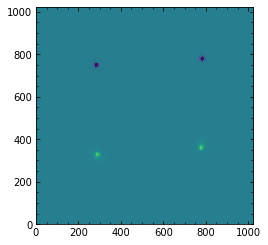

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03501_03550.fits
2
100 150 3551 3600
150 200 3601 3650


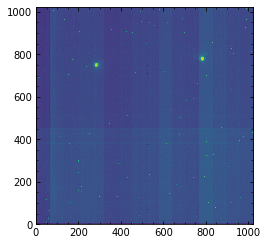

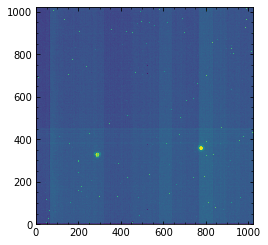


bkg image: 50
data image: 50
working on:  451 - 1024


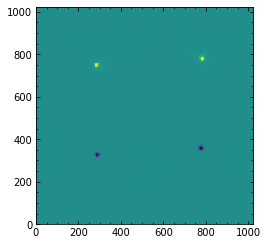

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03551_03600.fits
3
150 200 3601 3650
200 250 3651 3700


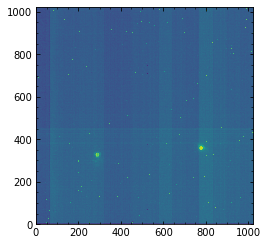

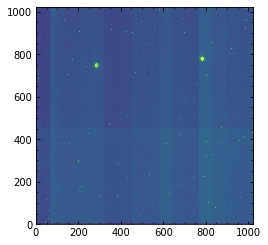


bkg image: 50
data image: 50
working on:  451 - 1024


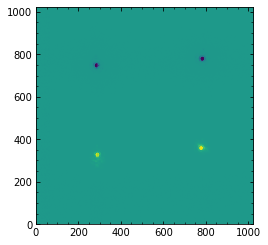

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03601_03650.fits
4
200 250 3651 3700
250 300 3701 3750


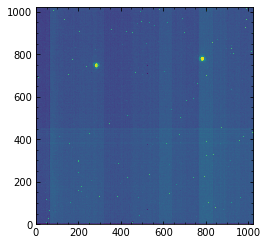

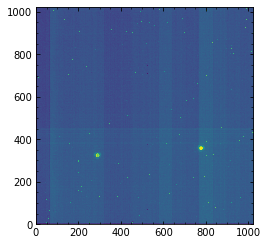


bkg image: 50
data image: 50
working on:  451 - 1024


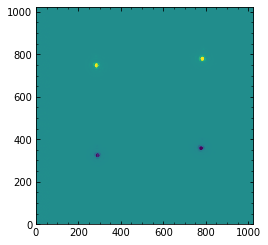

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03651_03700.fits
5
250 300 3701 3750
300 350 3751 3800


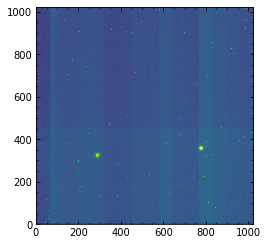

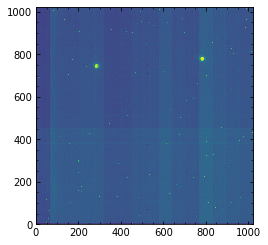


bkg image: 50
data image: 50
working on:  451 - 1024


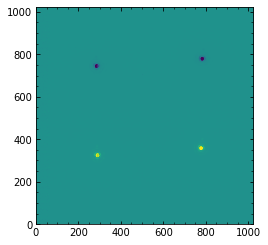

/Users/sbetti/Documents/dissertation_datasets/LMIRCam_Feb13/140213/3bkg_sub_1x1/unsats/HD39925/Lprime/final_lm_140213_03701_03750.fits
6
300 350 3751 3800
350 400 3801 3850


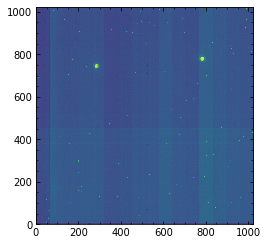

/Users/sbetti/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sbetti/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


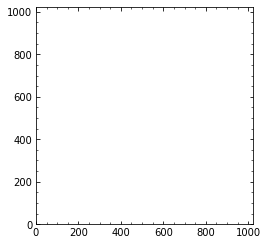

NotImplementedError: multi-dimensional slicing is not implemented

In [7]:
# first frame number in cube
min_num = 3451
# last frame number in cube
max_num = 3800

# the indices where the frames flip between nods.  It should be every 50 frames.  If it is NOT for some reason,
# you will need to go through the for loop and change all the 50s and 49s.  
data_val = np.arange(0,1000, 50)
nod_val = np.arange(50,1000,50)
nod_val = np.append(nod_val, -1)
print('data frame indices: ', data_val)
print('nod frame indices: ', nod_val)

# open cube
fil = datadir + f'2cubes/{target}/{filt}/lm_{date}_{min_num}_{max_num}.fits'
fil_data = fits.getdata(fil)
hdr = fits.getheader(fil)
print('number of nod subtractions that will occur: ', len(data_val))

# do data reduction
for i in np.arange(len(data_val)-1):
    print('i: ', i)
    if i+1 != len(data_val)-1:
        # if not the last set of frames: 
        print('min index:',data_val[i],'max index:', data_val[i+1], 'min frame num:', min_num, 'max frame num:', min_num+49)
        data = fil_data[data_val[i]:data_val[i+1], :,:]
        nums = f'0{min_num}_0{min_num+49}'
        min_num += 50
        print('NOD: min index:',nod_val[i], 'max index:', nod_val[i+1], 'min frame num:', min_num, 'max frame num:', min_num+49)
        data_nod = fil_data[nod_val[i]:nod_val[i+1], :,:]

        fig, (ax1, ax2) = plt.subplots(figsize=(8,6), nrows=1, ncols=2)
        ax1.imshow(data[0,:,:])
        ax1.set_title('raw frame data')
        ax2.imshow(np.median(data_nod, axis=0))
        ax2.set_title('median nod data')
        plt.show()
        bkg_nums = f'0{min_num}-0{min_num+49}'
        print()
        # do nod subtraction
        run(data_nod, data, nums, bkg_nums)
    
    if i+1 == len(data_val)-1:
        # if it is the second to last set of frames.
        print('min index:',data_val[i],'max index:', data_val[i+1], 'min frame num:', min_num, 'max frame num:', min_num+49)
        data = fil_data[data_val[i]:data_val[i+1], :,:]
        nums = f'0{min_num}_0{min_num+49}'
        min_num += 50
        print('NOD: min index:',nod_val[i], 'max index:', nod_val[i+1], 'min frame num:', min_num, 'max frame num:', max_num)
        data_nod = fil_data[nod_val[i]+1::, :,:]

        fig, (ax1, ax2) = plt.subplots(figsize=(8,6), nrows=1, ncols=2)
        ax1.imshow(data[0,:,:])
        ax1.set_title('raw frame data')
        ax2.imshow(np.median(data_nod, axis=0))
        ax2.set_title('median nod data')
        plt.show()
        bkg_nums = f'0{min_num}-0{min_num+49}'
        print()

        run(data_nod, data, nums, bkg_nums)
        
            
    if i+1 == len(data_val)-1:
        # if it is the last set of frames.
        print('max index:', data_val[i+1], 'min frame num:', min_num, 'max frame num:', max_num)
        print('NOD: min index:',nod_val[i-1], 'max index:', nod_val[i], 'min frame num:', min_num-50, 'max frame num:', min_num-1)
       
        data = fil_data[data_val[i+1]::, :,:]
        nums = f'0{min_num}_0{max_num}'

        data_nod = fil_data[nod_val[i-1]:nod_val[i]+1, :,:]
        fig, (ax1, ax2) = plt.subplots(figsize=(8,6), nrows=1, ncols=2)
        ax1.imshow(data[0,:,:])
        ax1.set_title('raw frame data')
        ax2.imshow(np.median(data_nod, axis=0))
        ax2.set_title('median nod data')
        plt.show()
        
        bkg_nums = f'0{min_num-50}-0{min_num-1}'
        print()
        run(data_nod, data, nums, bkg_nums)
    